In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import os
from syndirella.check_inputs import get_exact_hit_names

## Installation

Run in terminal: 

```
conda create -n syndirella python=3.12
conda activate syndirella
pip install --upgrade syndirella
syndirella -h
```

## Automatic routes

In [3]:
# Load examples input
df = pd.read_csv('syndirella_input_example_automatic.csv')
df

,smiles,hit1,hit2,hit3,template,compound_set
0,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Ax0556a,Ax0566a,NaN,Ax0310a,syndirella_auto_1
1,O=C1NCCC1C(=O)N1CCCC(NCc2ccccc2)C1,Ax0365a,Ax0528a,NaN,Ax0310a,syndirella_auto_1
2,CC(=O)Nc1cc(CC(=O)NCC(NC(=O)CCl)c2cccnc2)c(NC(...,1346a,NaN,NaN,Ax1346a,syndirella_auto_1
3,O=C(Cc1cn[nH]c1CC(=O)N1CCCC(C(F)(F)F)C1)NC1CC1,X0926,x1346,x1019,X0926,syndirella_auto_1


Notice the different formats of the values for hits and template. The values in the hit columns must contain significant identifiers that match to their short code in the `Code` column of the `metadata.csv` which are used to identify the `Long code` in the SDF. 

In [4]:
metadata = pd.read_csv('fragments/metadata.csv')
metadata[['Code', 'Long code']].head()

,Code,Long code
0,Ax0556a,A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1
1,Ax0450a,A71EV2A-x0450_A_201_1_A71EV2A-x0526+A+147+1
2,Ax0451a,A71EV2A-x0451_A_201_1_A71EV2A-x0526+A+147+1
3,Ax0469a,A71EV2A-x0469_A_147_1_A71EV2A-x0469+A+147+1
4,Ax0473a,A71EV2A-x0473_A_147_1_A71EV2A-x0526+A+147+1


The values for the template column must be as specific as possible to the file name of the template used. 

In [5]:
os.listdir('fragments/templates')

['Ax1346a_apo-desolv.pdb', 'Ax0926a_apo-desolv.pdb', 'Ax0310a_apo-desolv.pdb']

### Designs

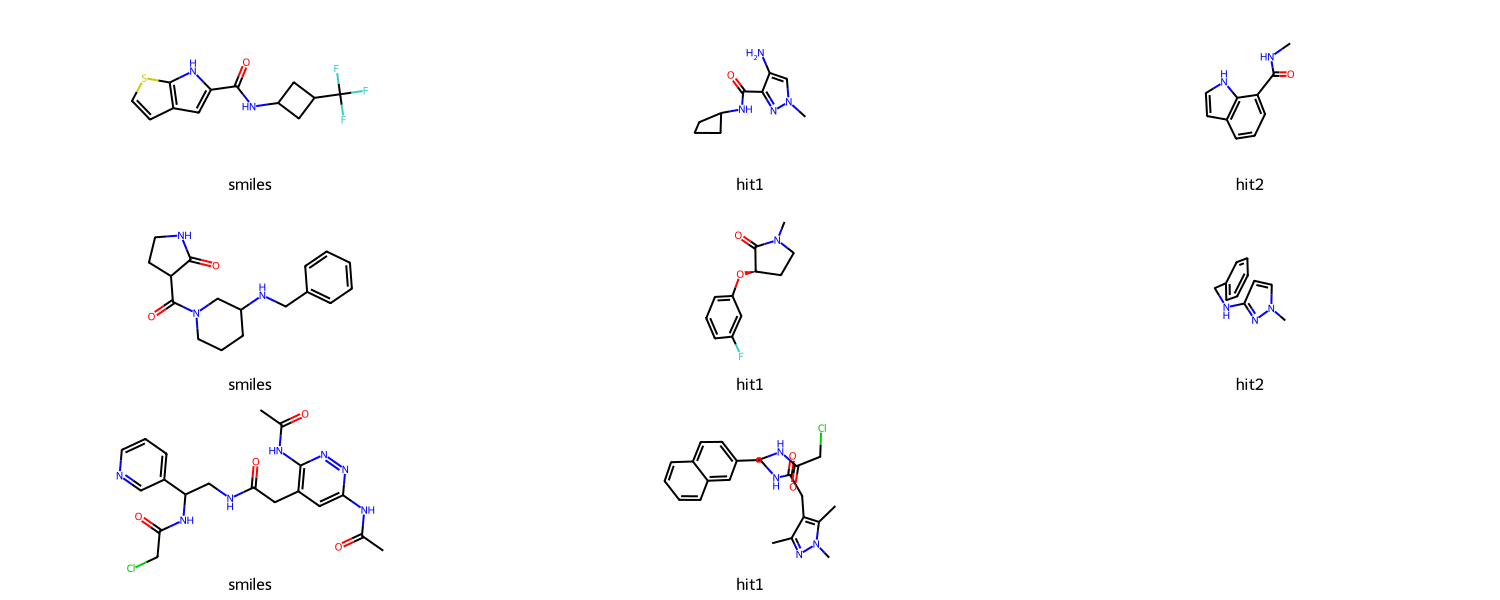

In [6]:
df['long_codes'] = df.apply(lambda x: get_exact_hit_names(row=x, metadata_path='fragments/metadata.csv', hits_path='fragments/A71EV2A_combined.sdf'), axis=1)
frag_mols = Chem.SDMolSupplier('fragments/A71EV2A_combined.sdf')
mols = df.apply(lambda x: [Chem.MolFromSmiles(x['smiles'])] + [frag_mol for frag_mol in frag_mols if frag_mol.GetProp('_Name') in x['long_codes']], axis=1)
mols = mols.explode()
labels = [['smiles'] + ['hit' + str(i) for i in range(1, 3)]] * 3
labels = [item for sublist in labels for item in sublist]
Draw.MolsToGridImage(mols[:-4], legends=labels, molsPerRow=3, subImgSize=(500, 200)) # first 2

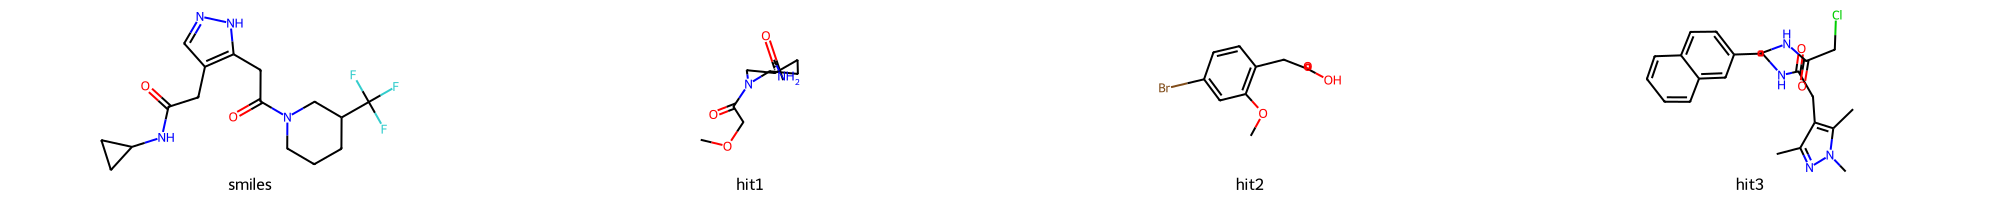

In [7]:
labels = ['smiles'] + ['hit' + str(i) for i in range(1, 4)]
Draw.MolsToGridImage(mols[-4:], legends=labels, molsPerRow=4, subImgSize=(500, 200)) # last 1

### Run

Run pipeline with automatic example:
```
export MANIFOLD_API_KEY=[KEY]
export BASE=[PATH_TO_SYNDIRELLA_EXAMPLE_IN_REPO]
export HOME=[path_to_home] # ex. export HOME=/home/jovyan
syndirella --input $BASE/syndirella_input_example_automatic.csv --output $HOME/output --templates $BASE/fragments/templates/ --hits_path $BASE/fragments/A71EV2A_combined.sdf --metadata $BASE/fragments/metadata.csv --batch_num 5
```

## Manual Routes

In [8]:
df = pd.read_csv('syndirella_input_example_manual.csv')
df

,smiles,reaction_name_step1,reactant_step1,reactant2_step1,product_step1,reaction_name_step2,reactant_step2,product_step2,reaction_name_step3,reactant_step3,hit1,hit2,hit3,template,compound_set
0,CCOC(=O)c1cc(NC(=O)CC#N)n(C)n1,Amide Schotten-Baumann with amine,N#CCC(=O)Cl,CCOC(=O)c1cc(N)n(C)n1,NaN,NaN,NaN,NaN,NaN,NaN,Ax0556a,Ax0310a,NaN,Ax0310a,syndirella_manual
1,CC(=O)N(C)c1ccc(NCc2cccc(C(C)C)c2)cn1,Amide Schotten-Baumann with amine,CNc1ccc(I)cn1,CC(=O)Cl,CC(=O)N(C)c1ccc(I)cn1,N-nucleophilic aromatic substitution,CC(C)c1cccc(CN)c1,NaN,NaN,NaN,Ax0310a,Ax0365a,NaN,Ax0310a,syndirella_manual
2,CC(=O)Nc1c(CC(=O)NC(CNC(=O)CCl)c2ccc3ccccc3c2)...,Amidation,O=C(O)CB(O)O,NCC(N)c1ccc2ccccc2c1,NCC(NC(=O)CB(O)O)c1ccc2ccccc2c1,Amidation,O=C(O)CCl,O=C(CCl)NCC(NC(=O)CB(O)O)c1ccc2ccccc2c1,Sp3-sp2 Suzuki coupling,CC(=O)Nc1c(Br)c(C)nn1C,x1346,NaN,NaN,x1346,syndirella_manual


Here the exact retrosynthesis routes are shown. It is mostly self-explanatory, but an important note is that for all reactions after step 1, there is only 1 reactant listed. The product of the previous step is the other reactant (if a bimolecular reaction). 

### Routes

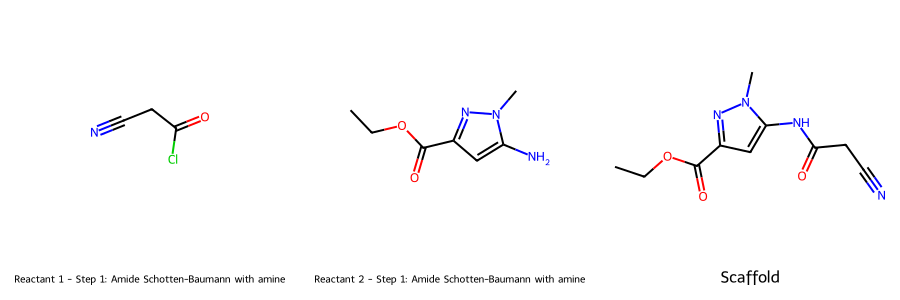

In [9]:
# Function to create RDKit molecules and grid image
def display_reactions_from_df(df, num_steps):
    df = df.fillna(value='None')
    
    mols = []
    legends = []

    for index, row in df.iterrows():
        # Step 1 Reactants and Product
        if row['reactant_step1'] != 'None':
            mols.append(Chem.MolFromSmiles(row['reactant_step1']))
            legends.append(f"Reactant 1 - Step 1: {row['reaction_name_step1']}")
        if row['reactant2_step1'] != 'None':
            mols.append(Chem.MolFromSmiles(row['reactant2_step1']))
            legends.append(f"Reactant 2 - Step 1: {row['reaction_name_step1']}")
        if row['product_step1'] != 'None':
            mols.append(Chem.MolFromSmiles(row['product_step1']))
            legends.append(f"Product - Step 1: {row['reaction_name_step1']}")
        
        # Step 2 Reactants and Product (if present)
        if row['reactant_step2'] != 'None':
            mols.append(Chem.MolFromSmiles(row['reactant_step2']))
            legends.append(f"Reactant - Step 2: {row['reaction_name_step2']}")
        if row['product_step2'] != 'None':
            mols.append(Chem.MolFromSmiles(row['product_step2']))
            legends.append(f"Product - Step 2: {row['reaction_name_step2']}")
        
        # Step 3 Reactants and Product (if present)
        if row['reactant_step3'] != 'None':
            mols.append(Chem.MolFromSmiles(row['reactant_step3']))
            legends.append(f"Reactant - Step 3: {row['reaction_name_step3']}")
            
        # Final product
        mols.append(Chem.MolFromSmiles(row['smiles']))
        legends.append("Scaffold")
    
    # Draw the molecules with legends underneath
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), legends=legends)
    return img

display_reactions_from_df(df[:1], num_steps=1)

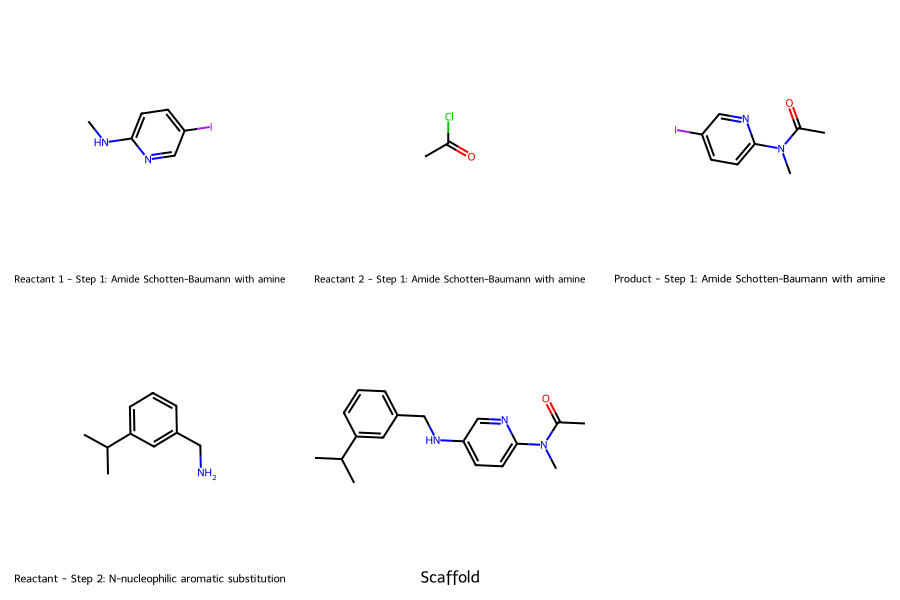

In [10]:
display_reactions_from_df(df[1:2], num_steps=3)

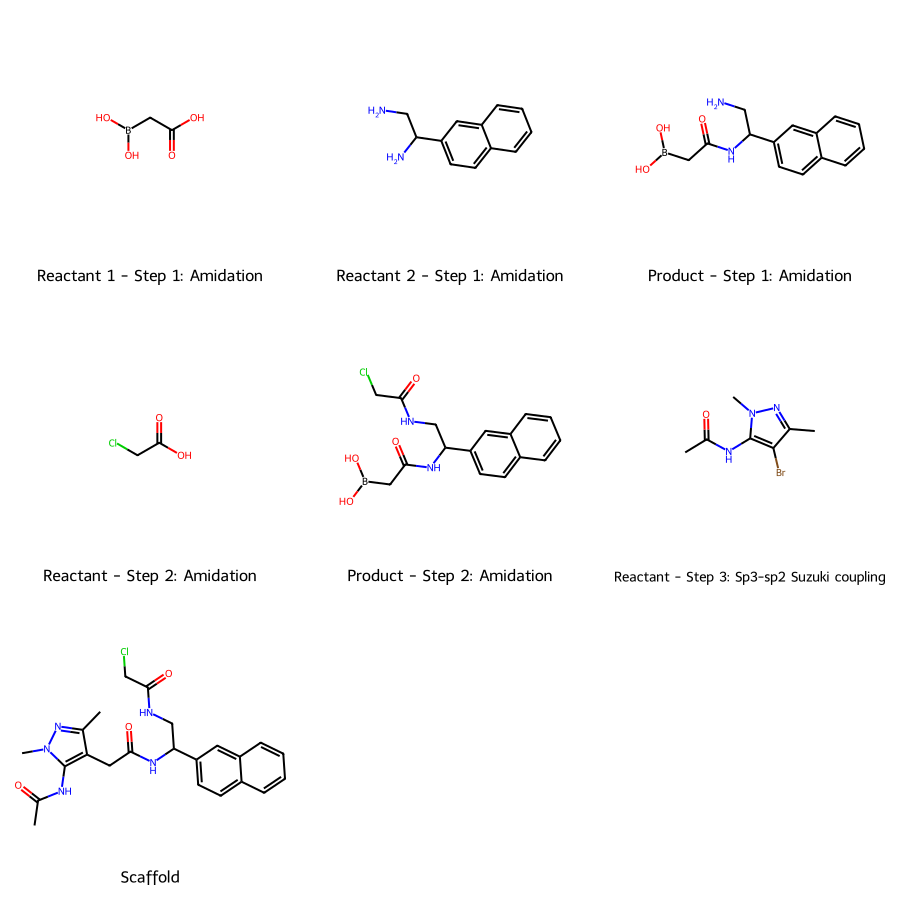

In [11]:
display_reactions_from_df(df[2:3], num_steps=4)

### Run

Run with manual flag:

```
export MANIFOLD_API_KEY=[KEY]
export BASE=[PATH_TO_SYNDIRELLA_EXAMPLE_IN_REPO]
export HOME=[path_to_home] # ex. export HOME=/home/jovyan
syndirella --input $BASE/syndirella_input_example_automatic.csv --output $HOME/output --templates $BASE/fragments/templates/ --hits_path $BASE/fragments/A71EV2A_combined.sdf --metadata $BASE/fragments/metadata.csv --batch_num 5 --manual
```

## Outputs

The first thing you should look at after running is the output csv which contains stats for ecah of the scaffold elaborations.

In [12]:
# open up output csv to get a high level overview of the run
output_csv_path = None # replace this with the path to: syndirella_input_example_automatic_output_YYYYMMDD_HHMM.csv
df = pd.read_csv(output_csv_path)
df

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

The final output is the `to_hippo.pkl.gz` which contains all the information to produce the elaborations. This includes, the synthesis route, placement, and other metadata. 

In [24]:
# open to_hippo.pkl.gz
# the to_hippo.pkl.gz is contained within each scaffold directory. 
to_hippo_path = None # replace with something like this: output/OQOLMCJQPJBXLR-UHFFFAOYSA-N/OQOLMCJQPJBXLR-UHFFFAOYSA-N_b45Xnu_to_hippo.pkl.gz
df = pd.read_pickle(to_hippo_path)
df